# Preprocessing - PAN 2012 Training Dataset

In [1]:
from google.colab import drive
from config import *
from utils import *

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sqlite
import numpy as np
import re

%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Increases the size limit of DataFrame columns
pd.set_option('display.max_colwidth', 500)

**Connecting to SQLite**


In [4]:
connection = sqlite.connect('database.db')

print("Connection established!");

Connection established!


**Import file with sexual predators labels from training dataset**

In [5]:
SEXUAL_PREDATORS = getSexualPredatorsTrainingDataset(DRIVE_PATH)

print('Number of sexual predators:', len(SEXUAL_PREDATORS))

Number of sexual predators: 142


## Functions

In [6]:
def getDatasetInformation(df):
  print('UPDATED DATASET INFORMATION')
  print('----------------------------------------------\n')

  print('Number of conversations: ', len(df['conversation_id'].value_counts()))
  print('Number of messages: ', len(df['message']))
  print('Number of authors: ', len(df['author'].value_counts()))
  print('-')

  # Returns only messages from authors who are sexual predators
  query = '''SELECT * FROM conversations WHERE author in (%s)''' % ','.join('?'*len(SEXUAL_PREDATORS))
  aux = pd.read_sql(query, connection, params=SEXUAL_PREDATORS)

  print('Number of predatory conversations: ', len(aux['conversation_id'].unique()))
  print('Number of messages sent by sexual predators: ', len(aux['message']))
  print('Number of sexual predators: ', len(aux['author'].unique()))

In [7]:
def getConversationsWithMoreWords(df):
  aux = df.copy()
  aux['words'] = df['message'].str.count(' ') + 1

  return aux[['conversation_id', 'words', 'message']].sort_values(by=['words'], ascending = False).head(10)

## Import training dataset

In [8]:
dfBase = pd.read_csv(DRIVE_PATH + 'databases/training.csv', sep=';')

In [9]:
dfBase

,conversation_id,line,author,time,message
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola.
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi.
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up?
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton.
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you?
...,...,...,...,...,...
903602,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok
903603,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow
903604,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok
903605,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa


In [10]:
# Info

dfBase.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903607 entries, 0 to 903606
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   conversation_id  903607 non-null  object
 1   line             903607 non-null  int64 
 2   author           903607 non-null  object
 3   time             903607 non-null  object
 4   message          900629 non-null  object
dtypes: int64(1), object(4)
memory usage: 34.5+ MB


In [11]:
# Number of null values by column

dfBase.isnull().sum()

conversation_id       0
line                  0
author                0
time                  0
message            2978
dtype: int64

## Preprocessing

**Creating a copy of the message column for message comparison**

In [12]:
dfBase['original_message'] = dfBase['message']

In [13]:
dfBase.head()

,conversation_id,line,author,time,message,original_message
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,Hola.,Hola.
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi.,hi.
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up?,whats up?
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton.,not a ton.
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you?,you?


In [14]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### Information before preprocessing

In [15]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66927
Number of messages:  903607
Number of authors:  97689
-
Number of predatory conversations:  2016
Number of messages sent by sexual predators:  40978
Number of sexual predators:  142


### Number of words per message

In [16]:
getConversationsWithMoreWords(dfBase)

,conversation_id,words,message
207418,d6c836f0eb4b27b86eabbd8b216331e1,55855.0,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
207424,d6c836f0eb4b27b86eabbd8b216331e1,28249.0,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
301098,ef830220f9b141ef2cf3c19e345c6cac,8397.0,GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HA...
207405,d6c836f0eb4b27b86eabbd8b216331e1,5779.0,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
750718,d5e5ac5fe57798fac61ba9ca2d61c745,3081.0,"lets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play ..."
463292,71d6ec839d6fefa1d4ed0454cf34b77e,2839.0,20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on...
771481,eda07fd35ebd98b12a03687d479db47c,2784.0,° Û °° ° ° ± ÛÛÛÛßßß ßßÛÛ°±°°ÛÛÛÛÛ Û ° °\n Û ° °°°°° °° ÛÛÛÛßß Ü °°°°°ÛÛÛÛ ±Ü °\n Û °°° °° ° ÛÛÛÛß ÜÛÛÛÛÛÛ Û Û ° ° ÛÛÛ ±±Û °\n Û °°° ° ° Ûß Ûßß Û ÛÛ °Û ±ÛÛ ° ° °\n° Û ° ÛÛ ßÜÛ °° ±°ÛÛ \n Û ° ÛÛ Û ° ° ±±±±ÛÛ ° ° °\n Û ÛÛ ßÛ² °°° ...
578082,568fa57c91fe53d29dde15f5dac5f1e3,2196.0,Ask me questions and I will answer them honestly. Ask me questions and I will answer them honestly. Ask me questions and I will answer them honestly. Ask me questions and I will answer them honestly. Ask me questions and I will answer them honestly. Ask me questions and I will answer them honestly. Ask me questions and I will answer them honestly. Ask me 

### 1- Delete null messages

In [17]:
dfBase.dropna(subset=['message'], inplace=True)
dfBase.reset_index(drop=True, inplace=True)

# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

In [18]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66914
Number of messages:  900629
Number of authors:  97671
-
Number of predatory conversations:  2015
Number of messages sent by sexual predators:  40729
Number of sexual predators:  142


### 2- Convert messages to lowercase

In [19]:
dfBase['message'] = dfBase['message'].str.lower()

In [20]:
dfBase.head()

,conversation_id,line,author,time,message,original_message
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola.,Hola.
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi.,hi.
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up?,whats up?
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton.,not a ton.
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you?,you?


In [21]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 3- Remove HTML character entities and \\n, \\r and \\t

#### Remove HTML character entities

In [22]:
dfBase['message'] = dfBase['message'].str.replace('&lt;', '') # <
dfBase['message'] = dfBase['message'].str.replace('&gt;', '') # >
dfBase['message'] = dfBase['message'].str.replace('&amp;', '') # &
dfBase['message'] = dfBase['message'].str.replace('&quot;', '') # " (double quotes)
dfBase['message'] = dfBase['message'].str.replace('&apos;', '') # ' (single quotes)

In [23]:
# Example

dfBase[['message', 'original_message']][18:28]

,message,original_message
18,"its nice, isnt it?","It&apos;s nice, isn&apos;t it?"
19,yeah. always enjoy visiting.,Yeah. Always enjoy visiting.
20,which island you on oahu?,Which Island you on Oahu?
21,married?,married?
22,im assuming since you went on a family trip :p,i&apos;m assuming since you went on a &apos;family&apos; trip :p
23,yeah. just found this site a few days ago.,yeah. Just found this site a few days ago.
24,"yeah, oahu.","Yeah, Oahu."
25,curious to the whole random thing,Curious to the whole &quot;random thing&quot;
26,"pretty crazy the individuals you meet, isnt it?","Pretty crazy the individuals you meet, isn&apos;t it?"
27,its been eye opening for sure.,It&apos;s been eye opening for sure.


#### Remove \\n, \\r e \\t

In [24]:
i=0
j=0
for message in dfBase['message']:
  m = re.search(r'\\n', message)
  n = re.search(r'\n', message)
  if m:
    i=i+1

  if n:
    j=j+1

print('Number of \\\\n:', i)
print('Number of \\n:', j)

Number of \\n: 192
Number of \n: 1687


**Replaces \n, \r and \t with empty space because some words have no space between them and punctuation**

In [25]:
dfBase['message'] = dfBase['message'].str.replace(r'\\n|\\r|\\t', ' ', regex=True)
dfBase['message'] = dfBase['message'].str.replace(r'\n|\r|\t', ' ', regex=True)

In [26]:
# Example

dfBase[dfBase['conversation_id'] == '65ed509ed4f8637d1dd5cef866b1ba38'][['message', 'original_message']][6:15]

,message,original_message
240489,i have,i have
240490,sorry,sorry
240491,torin: vim regexp's predate a lot of stuff.,Torin: vim regexp's predate a lot of stuff.
240492,torin: one of them is the definition of ' ',Torin: one of them is the definition of '\n'
240493,hmm,hmm
240494,"in vim is \0 in c, or nul","\n in vim is \0 in C, or NUL"
240495,i want a new line,i want a new line
240496,is 'newline',\r is 'newline'
240497,ohh,ohh


In [27]:
# Example

dfBase[dfBase['conversation_id'] == 'd6c836f0eb4b27b86eabbd8b216331e1'][['message', 'original_message']][0:1]

,message,original_message
206773,ficial messages from omegle will not be sent with the label stranger:. strangers claiming to represent omegle are lying.youre now chatting with a random stranger. say hi! official messages from omegle will not be sent with the label stranger:. strangers claiming to represent omegle are lying.youre now chatting with a random stranger. say hi! official messages from omegle will not be sent with the label stranger:. strangers claiming to represent omegle are lying.youre now chatting with a rand...,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...


In [28]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 4- Remove URLs

In [29]:
i=0
for message in dfBase['message']:
  m = re.search('https?:\/\/\S+|www\.\S+', message)
  if m:
    i=i+1
    #print(m.group(0))

print('Number of URLs:', i)

Number of URLs: 26878


In [30]:
dfBase['message'] = dfBase['message'].str.replace('https?:\/\/\S+|www\.\S+', '', regex=True)

In [31]:
# Example

dfBase[dfBase['conversation_id'] == 'aa7fe505c5ce8ea125c3c146224efda5'][['message', 'original_message']][9:28]

,message,original_message
42377,--,-- http://lists.w3.org/Archives/Member/w3c-html-cg/2007OctDec/0174.html
42378,or to even consider that?,or to even consider that?
42379,or to come up with some compromise?,or to come up with some compromise?
42380,how is any of this consensus building?,how is any of this consensus building?
42381,"i don't know enough context, but i read feel obligation not feel like","I don't know enough context, but I read &quot;feel obligation&quot; not &quot;feel like&quot;"
42382,i've seen them ask members who asked for charter changes what changes they want,I've seen them ask Members who asked for charter changes what changes they want
42383,"not the smartest thing to put it to the vote if there are some process rules that oblige them, granted","not the smartest thing to put it to the vote if there are some process rules that oblige them, granted"
42384,i haven't seem them talk to members who oppose charter changes to explain their reasoning,I haven't seem them talk to Members who oppose charter changes to explain their reasoning
42385,i don't believe any process rule obliges them to recharter,I don't believe any process rule obliges them to recharter
42386,and i don't believe that is their claim,and I don't believe that is their claim


In [32]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 5- Remove punctuation, unknown and accented letters

**Replaces punctuation with space because some words have no space between them and punctuation**

**Only single quotes don't need space**

In [33]:
dfBase['message'] = dfBase['message'].str.replace('\'', '')
dfBase['message'] = dfBase['message'].str.replace('[^a-z0-9\s]', ' ', regex=True)

In [34]:
# Example

dfBase[dfBase['conversation_id'] == '93e065929a4140689227b427415f5abb'][['message', 'original_message']][40:]

,message,original_message
43440,rickrolled,rickrolled
43441,never gonna ...,"…………………………………………. …………………………….-~~”””’~~–,,_\r\n………………………………………….. …………………………….,-~”-,:::::::::::::::::::”-,\r\n………………………………………….. ………………………..,~”::::::::’,::::::: :::::::::::::|’,\r\n………………………………………….. ………………………..|::::::,-~”’___””~~–~”’:}\r\n………………………………………….. ………………………..’|:::::|: : : : : : : : : : : : : :\r\n………………………………………….. ………………………..|:::::|: : :-~~—: : : —–: |\r\n………………………………………….. ……………………….(_”~-’: : : : : : : : :\r\n………………………………………….. ………………………..”’~-,|: : : : : : ~—’: : : :,’–never gon..."


In [35]:
# Example

dfBase[dfBase['conversation_id'] == '65bbcf71365f6580e4ddc5f26e039c51'][['message', 'original_message']]

,message,original_message
59727,hi,Hi!
59728,its impolite not to return greetings,It&apos;s impolite not to return greetings.
59729,heil hitler ...,_______________HEIL HITLER______________ \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n????????????????????????????????? \n?????????????????????...


In [36]:
# Example

dfBase[dfBase['conversation_id'] == '2f07eda4b81036ae3aa5be01ddc7515b'][['message', 'original_message']][5:15]

,message,original_message
84249,15 female i dont wanna know where youre from so why do you wanna know mine,"15, female. i don&apos;t wanna know where you&apos;re from, so why do you wanna know mine."
84250,,---------------------
84251,d,;D
84252,,[:
84253,,---------------------------
84254,im 15 male from germany,im 15 male from germany
84255,,____________________________________________________________________
84256,do u have msn,do u have msn
84257,,?
84258,p,:P


In [37]:
# Example

dfBase[dfBase['conversation_id'] == 'bc2043c280dcf4bcd067fe13f8ca7555'][['message', 'original_message']][5:20]

,message,original_message
5519,,ÔÓ ÚÓ˜ÌÓ ÛÚ?Â ?Â ?‡Á·Â?‡
5520,lord sithius blagodarsko,Lord_Sithius blagodarsko
5521,luda glawa edno diablo,Luda_Glawa: edno diablo ?
5522,deathmaster,"[Deathmaster], ÒÚ‡‚‡"
5523,,Ó·‡˜Â ‰‡È ‰‡ ÒÂ Ó·Á‡ÎÓÊËÏ Ô?Â‰Ë ÚÓ‚‡
5524,,??
5525,,ÒÔÓ?Â‰ ÚÂ· ÒÎÂ‰ ÍÓÎÍÓ ‚?ÂÏÂ ?Â Á‡·ËÂ Ò??‚??‡?
5526,,:-)))
5527,20,20 ÏËÌÛÚË?
5528,,Ì?Ï‡ ‰‡ Á‡·ËÂ


In [38]:
# Example

dfBase[dfBase['conversation_id'] == 'eda07fd35ebd98b12a03687d479db47c'][['message', 'original_message']]

,message,original_message
768863,...,° Û °° ° ° ± ÛÛÛÛßßß ßßÛÛ°±°°ÛÛÛÛÛ Û ° °\n Û ° °°°°° °° ÛÛÛÛßß Ü °°°°°ÛÛÛÛ ±Ü °\n Û °°° °° ° ÛÛÛÛß ÜÛÛÛÛÛÛ Û Û ° ° ÛÛÛ ±±Û °\n Û °°° ° ° Ûß Ûßß Û ÛÛ °Û ±ÛÛ ° ° °\n° Û ° ÛÛ ßÜÛ °° ±°ÛÛ \n Û ° ÛÛ Û ° ° ±±±±ÛÛ ° ° °\n Û ÛÛ ßÛ² °°° ...
768864,ok,ok
768865,,?
768866,n1,n1


In [39]:
# Example

dfBase[dfBase['conversation_id'] == '9d9909eafba749e02d94aca80e18a298'][['message', 'original_message']]

,message,original_message
64046,,"________ ________ _________ ____________;_\n - ______ \ - ______ \ / _____ //. . ._______/\n / / / // / / //_/ / // ___ /\n / / / // / / / .-&apos;//_/|_/,-&apos;\n / / / // / / / .-&apos;.-&apos;\n / / / // / / / / /\n / / / // / / / / /\n/ /_____/ // /_____/ / / /\n\________- \________- /_/"
64047,are u turk sh horny g rl,are u turk?sh horny g?rl?
64048,fuck,FUCK
64049,,"________ ________ _________ ____________;_\n - ______ \ - ______ \ / _____ //. . ._______/\n / / / // / / //_/ / // ___ /\n / / / // / / / .-&apos;//_/|_/,-&apos;\n / / / // / / / .-&apos;.-&apos;\n / / / // / / / / /\n / / / // / / / / /\n/ /_____/ // /_____/ / / /\n\________- \________- /_/"


In [40]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 6- Remove empty spaces in sequence

In [41]:
i=0
for message in dfBase['message']:
  m = re.search('\s{2,}', message)
  if m:
    i=i+1

print('Number of messages with more than 2 spaces in sequence:', i)

Number of messages with more than 2 spaces in sequence: 311178


In [42]:
# Example of conversation with many spaces

dfBase[dfBase['conversation_id'] == '67a80b498aa446a0ff72ff8448f6ec5e']['message']

184174                                                                             gmail   inbox for  email  
184175                                                                                  you have 20 new mails
184176                                                                                                       
184177                            sl   subject                                                  author       
184178                                                                                                       
184179                   0    njoi                                                     anagha missin         
184180                       1        happy friendship day                                 neeraj            
184181                                                                     traceback  most recent call last  
184182                                                                     file check gmail py  line 50  in  
184183    

In [43]:
# Remove spaces in sequence
dfBase['message'] = dfBase['message'].str.replace('\s{2,}', ' ', regex=True)

# Remove spaces at the beginning and end
dfBase['message'] = dfBase['message'].apply(lambda m: m.strip())

In [44]:
# Example

dfBase[dfBase['conversation_id'] == '67a80b498aa446a0ff72ff8448f6ec5e']['message']

184174                                                                               gmail inbox for email
184175                                                                               you have 20 new mails
184176                                                                                                    
184177                                                                                   sl subject author
184178                                                                                                    
184179                                                                                0 njoi anagha missin
184180                                                                       1 happy friendship day neeraj
184181                                                                     traceback most recent call last
184182                                                                      file check gmail py line 50 in
184183                               

In [45]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 7- Delete empty messages

In [46]:
print('Number of empty messages:', len(dfBase[dfBase['message'] == '']))

Number of empty messages: 27427


In [47]:
# 50 first examples

dfBase[dfBase['message'] == ''][['conversation_id', 'message', 'original_message']].head(50)

,conversation_id,message,original_message
138,2c8125f8376aa2515c19222ba4213c28,,?
176,7de43ad0a0a236d48a580c411eb7feae,,?
225,7b8bd13557382d5aa86cf3e3b90acaa5,,http://dvcs.w3.org/hg/webevents/raw-file/tip/touchevents.html
239,7b8bd13557382d5aa86cf3e3b90acaa5,,http://www.w3.org/2008/webapps/wiki/Selector-based_Mutation_Events
240,7b8bd13557382d5aa86cf3e3b90acaa5,,http://www.w3.org/2008/webapps/wiki/MutationReplacement
243,7b8bd13557382d5aa86cf3e3b90acaa5,,https://github.com/jeresig/nodelist
252,7b8bd13557382d5aa86cf3e3b90acaa5,,http://www.w3.org/2008/webapps/track/issues/121
253,7b8bd13557382d5aa86cf3e3b90acaa5,,http://www.w3.org/2008/webapps/track/products/2
258,7b8bd13557382d5aa86cf3e3b90acaa5,,http://www.w3.org/2008/webapps/track/issues/122
411,dd6f7c7ef644abca600d28b5afd8c191,,;)


**Replace empty spaces with null**

In [48]:
dfBase['message'].replace('', np.nan, inplace=True)

In [49]:
# Number of null values by column

dfBase.isnull().sum()

conversation_id         0
line                    0
author                  0
time                    0
message             27427
original_message        0
dtype: int64

In [50]:
# Example of messages sent by sexual predators that will be deleted

dfBase[(dfBase['message'].isnull()) & (dfBase['author'] == '6f35a1f69fd4ae82056e4bc6a8a84575')]

,conversation_id,line,author,time,message,original_message
40658,d0d1ddf8f46982053911522c825eaa9c,28,6f35a1f69fd4ae82056e4bc6a8a84575,00:26,NaN,:-*
40666,d0d1ddf8f46982053911522c825eaa9c,36,6f35a1f69fd4ae82056e4bc6a8a84575,00:32,NaN,:-*
40678,d0d1ddf8f46982053911522c825eaa9c,48,6f35a1f69fd4ae82056e4bc6a8a84575,00:40,NaN,:-*
40693,d0d1ddf8f46982053911522c825eaa9c,63,6f35a1f69fd4ae82056e4bc6a8a84575,00:49,NaN,:-*
40739,d0d1ddf8f46982053911522c825eaa9c,109,6f35a1f69fd4ae82056e4bc6a8a84575,01:22,NaN,?
40753,d0d1ddf8f46982053911522c825eaa9c,123,6f35a1f69fd4ae82056e4bc6a8a84575,01:29,NaN,:-*
84299,cf6cafbf41d2bd9b32ca79f8d7a0c2d2,29,6f35a1f69fd4ae82056e4bc6a8a84575,23:15,NaN,:-*
84338,cf6cafbf41d2bd9b32ca79f8d7a0c2d2,68,6f35a1f69fd4ae82056e4bc6a8a84575,23:33,NaN,?
184450,1d9e30fb1c0927e0d4b2fe9fba0c978e,2,6f35a1f69fd4ae82056e4bc6a8a84575,19:55,NaN,:(
272032,6ccbe120d7a4f257766f14ef08c308e9,1,6f35a1f69fd4ae82056e4bc6a8a84575,17:51,NaN,:-:-:-:-:-*


In [51]:
# Example of messages sent by sexual predators that will be deleted

dfBase[(dfBase['message'].isnull()) & (dfBase['author'] == 'c62283536cf6261e5ffbcb323c8a2571')]

,conversation_id,line,author,time,message,original_message
242802,d77287d1376bd8bcb9c8698e80df659d,3,c62283536cf6261e5ffbcb323c8a2571,23:53,NaN,=((
292581,16d491fbdf246883d536ef376a98e74a,4,c62283536cf6261e5ffbcb323c8a2571,01:00,NaN,=((
295366,7dc59c1557805b5a6d4ef276b8303300,29,c62283536cf6261e5ffbcb323c8a2571,14:17,NaN,?
300071,d1e1629e25817ecaf525d6164db296cb,54,c62283536cf6261e5ffbcb323c8a2571,22:23,NaN,?
620589,b84307c01eab52a2fdcdb629296c70c7,3,c62283536cf6261e5ffbcb323c8a2571,12:29,NaN,:-*
899270,1c7e6180909437ab3ab8191443e09e2e,4,c62283536cf6261e5ffbcb323c8a2571,22:30,NaN,=((


**Delete messages that are null**

In [52]:
dfBase.dropna(subset=['message'], inplace=True)
dfBase.reset_index(drop=True, inplace=True)

# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

In [53]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66702
Number of messages:  873202
Number of authors:  97287
-
Number of predatory conversations:  1972
Number of messages sent by sexual predators:  39798
Number of sexual predators:  142


### 8- Remove repeated letters in a word

In [54]:
"""
Adapted from https://github.com/biemt-pesc-coppe-ufrj/exemplosXexeo/blob/8438dcfd5ee5594123be1bcaa52e30a18c53e425/Norvig%20Simples/bimt_spell.py

"""

def removeRepeatedLetters(word):
  "Remove repeated letters in a word."

  return re.sub('([a-zA-Z])(?=(\\1){2})', '', word)

In [55]:
dfBase['message'] = dfBase['message'].apply(lambda m: removeRepeatedLetters(m))

In [56]:
# Example

dfBase[dfBase['conversation_id'] == 'fbf93ab0370b314128ab9d62ec6b56a2'][['message', 'original_message']]

,message,original_message
102,hi,hi
103,asl,asl
104,hi,Hi
105,helloo,hellloooo


In [57]:
dfBase[dfBase['conversation_id'] == '722b7a3329ddd4549c158370d53613f9'][['message', 'original_message']][25:]

,message,original_message
11886,i dnt speak it fluently,i dnt speak it fluently
11887,hhaa,hhaaa
11888,thatscos yu dont speak it at all,thatscos yu dont speak it at all
11889,im watchin sunday best its halarious,im watchin sunday best its halarious
11890,haha,haha
11891,i dont give a shit you fake,I DONT GIVE A SHIT YOU FAKE
11892,ffaakkerr,ffffaaakkkkerrrr


In [58]:
dfBase[dfBase['conversation_id'] == '01b187e109530bfa641cc1e16497e37c'][['message', 'original_message']][10:25]

,message,original_message
24822,we are soo useless,we are sooooooooo useless
24823,speak for yourself i could donate my liv never mind,"speak for yourself, I could donate my liv... never mind"
24824,come on teh warez download phast0r,come on teh warez download phast0r
24825,gasp,gasp
24826,anyone got crackz for openbsd 3 9,anyone got crackz for OpenBSD 3.9 ?
24827,d,:D
24828,scp teh good stuff email,scp teh-good-stuff <email/>
24829,hmm are there different versions whatever of the ports tree,"Hmm, are there different versions/whatever of the ports tree?"
24830,yes,yes
24831,hmmkay,Hmmkay


In [59]:
dfBase[dfBase['conversation_id'] == 'aa9d8c30d9f2f20bbf28d56c894dfa88'][['message', 'original_message']][120:]

,message,original_message
25367,wee,weeeeee
25368,im happy,im happy
25369,ru,ru?
25370,hlo,hlo?
25371,ru there,ru there?
25372,i gotta p brb,i gotta p brb
25373,kay bak,kay bak
25374,heelloo,heeellllooooooooooooo
25375,shawn,shawn
25376,wered u go,wered u go?


In [60]:
dfBase[dfBase['conversation_id'] == '6b0fbc8a53e4c63c092cc9d0bd0b463a'][['message', 'original_message']][33:]

,message,original_message
39353,helloo,hellloooooooo
39354,hey liu,hey liu
39355,hahahh,hahahh
39356,helloo,hellooo
39357,helloo,hellooo
39358,heklloo,heklllooo
39359,helloo,hellooo
39360,helloo,helloooo
39361,helloo,hellooo
39362,heloo,helooo


### 9- Remove repeated words in sequence

In [61]:
i=0
for message in dfBase['message']:
  m = re.search(r'\b(.+)\s+\1\b', message)
  if m and m.group(0).strip():
    i=i+1
    #print(m.group(0))

print('Number of messages with some repeated word::', i)

Number of messages with some repeated word:: 10426


In [62]:
# Remove repeated words
dfBase['message'] = dfBase['message'].apply(lambda m: removeRepeatedWordsInSequence(m))

# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

In [63]:
# Example

dfBase[dfBase['conversation_id'] == 'd6c836f0eb4b27b86eabbd8b216331e1'][['message', 'original_message']][0:6]

,message,original_message
200707,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
200708,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
200709,moii ooks suomest,moiiii ooks suomest ?
200710,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
200711,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...
200712,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Strange

In [64]:
# Example

dfBase[dfBase['conversation_id'] == 'ef830220f9b141ef2cf3c19e345c6cac'][['message', 'original_message']]

,message,original_message
290769,hey,hey
290770,asl,asl?
290771,gingers do have souls,GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HA...


In [65]:
# Example

dfBase[dfBase['conversation_id'] == '5c985f8a688a3e2fb6d310077dcccbcd'][['message', 'original_message']][10:18]

,message,original_message
21850,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!
21851,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!
21852,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger....
21853,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!
21854,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger....
21855,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger....
21856,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger....
21857,youre now chatting with a random stranger say hi,You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!You&apos;re now chatting with a random stranger. Say hi!


In [66]:
# Example

dfBase[dfBase['conversation_id'] == 'ac7dc47cf0b5c2b27bb3dd965d62322a'][['message', 'original_message']]

,message,original_message
434267,hey,hey
434268,asl,asl?
434269,pudi,PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI P...
434270,pudi,PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI PUDI P...


**Comparing amount of words before and after removing repeated words**

In [67]:
df = dfBase.copy()
df['words_before'] = df['original_message'].str.count(' ') + 1
df['words_after'] = df['message'].str.count(' ') + 1

df[['words_before', 'original_message', 'words_after', 'message']].sort_values(by=['words_before'], ascending = False).head(10)

,words_before,original_message,words_after,message
200726,55855,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...,47,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying
200732,28249,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...,47,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying
290771,8397,GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HAVE SOULS! GINGERS DO HA...,4,gingers do have souls
200713,5779,ficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represent Omegle are lying.You&apos;re now chatting with a random stranger. Say hi!\nOfficial messages from Omegle will not be sent with the label &apos;Stranger:&apos;. Strangers claiming to represe...,48,ficial messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying vvyguihjkroigfdvivgyu
725192,3081,"lets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play explosion knight quest seven, i go first and use lazer blast, 10 damagelets play ...",29,lets play explosion knight quest seven i go first and use lazer blast 10 damagelets play explosion knight quest seven i go first and use lazer blast 10 damage
447841,2839,20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet on cam20 m us lookin for girls to show their feet o

### Information after preprocessing

In [68]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  66702
Number of messages:  873202
Number of authors:  97287
-
Number of predatory conversations:  1972
Number of messages sent by sexual predators:  39798
Number of sexual predators:  142


### Number of words per message

In [69]:
getConversationsWithMoreWords(dfBase)

,conversation_id,words,message
271525,3c98f24025742ea1d9ea8b3990071732,2000,declining productivity an artificially high fixed exchange rate between the ruble and foreign currencies to avoid public turmoil and a chronic fiscal deficit were the background to the meltdown the economic cost of the first war in chechnya that is estimated at 5 billion not including the rebuilding of the ruined chechen economy was also a cause of the crisis in the first half of 1997 the russian economy showed some signs of improvement however soon after this the problems began to gradually...
198344,06649fab7088fa8a4c58ccd27ac4d3d8,1410,the city hung under a pall of grey the roiling mass of cloud above and distant thunder promising a storm the streets were empty with the exception of the few huddled figures going about their late afternoon business from the hills to the east the all encompassing fog began to descend making its way through the latticework of streets tendrils of mist inquisitively groping at the forms of buildings and unlit street lamps the insistent wind pulls the fog towards the outskirts of the city to a h...
98760,9862471a316571ab4bad3ae68cf72c5e,1058,what home computing technology spreadsheets about com spreadsheets the basics formulas and functions advanced share print free spreadsheets newsletter discuss in my forum how to use excel tutorials for beginners guide to excel 2003 by ted french about com guide see more about beginners guide to excel how to use excel sponsored links exceltodays market news opinions by market experts live market updatesmoneycontrol com excel charts in secondsautomatically summarize and assign data and reuse c...
198170,75fef10a08b0ce3b7cfc95348f9ae300,877,ebenin am na benchten gelip katk da buluniim ekoslovakyal la t ramad klar m z n ebesinin k ll a amc n ortalar ndan sa ve sola a yapm dillerini sikti imin evlad n ta annesini b yle tavana asiim ut saatiyle ma saati aras ndaki fark boyunca anneni atur utur k z arkada nla beraber g t rr ken kim engelleyebilir ki ebenin am n dikine sikerim g zl n sap n am na kodumun a t rma a z n skerim y z n pi g t n amc kba l anzorotun antilop ta aa yalam versiyonu seni taburenin zerine kart p berber ra yla be...
145015,1e27624c3009e13ab708d46babf06fc7,784,stranger hi you stranger hey you im a horny girl please me you my name is anna stranger uhm sure stranger my names rei stranger nice to fuck you ok d you i would love that stranger how big are your tits you medium size stranger they can fit stranger im into kinky shit is that ok you yes d you i dont mind you i saw my sister fuck her bf and i got horny stranger wow youre one slutty chick you lol thanks d you also bi stranger thats extremely slutty stranger you be lovin my cock long time you a...
564774,05f5b2119260313889c7b87d52bd1381,691,given the existence as uttered forth in the public works of puncher and wattmann of a personal god quaquaquaqua with white beard quaquaquaqua outside time without extension who from the heights of divine apathia divine athambia divine aphasia loves us dearly with some exceptions for reasons unknown but time will tell and suffers like the divine miranda with those who for reasons unknown but time will tell are plunged in torment plunged in fire whose fire flames if that continues and who can ...
140972,88b4a0b1c954f4f43c835c32e2d756de,639,stranger i am lord voldemort you ok stranger what is your name you my name is karen and im a professional psychologist stranger is that a muggle name stranger and a muggle job stranger you filthy mudblood stranger avada kedavra you were here today to talk about you thinking that you can do magic stranger i can do magic you and killing random eople stranger ive killed many random people via magic you damn i cant even solve this stranger the avada kedavra curse is my faithful friend you its ba...
388825,7c9e28cbc41d185e1fc31bbd577d1273,611,hello do you know jesus as your personal savior may the lord bless you with this ability from him and only him reme

### Number of authors per conversation

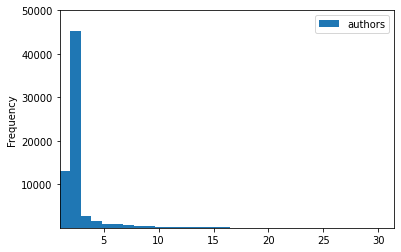

In [80]:
# Number of authors per conversation

query = '''SELECT conversation_id, count(distinct(author)) as authors
           FROM conversations 
           GROUP BY conversation_id 
           ORDER BY authors desc;'''

df = pd.read_sql(query, connection)
df.plot.hist(bins=30, ylim=(1,50000), xlim=(1))

### Number of messages per conversation

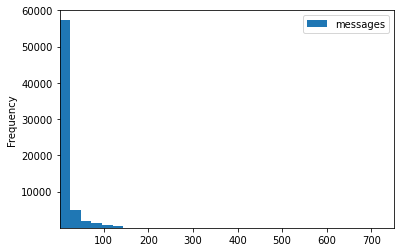

In [89]:
# Number of messages per conversation

query = '''SELECT conversation_id, count(distinct(message)) as messages
           FROM conversations 
           GROUP BY conversation_id 
           ORDER BY messages desc;'''

df = pd.read_sql(query, connection)
df.plot.hist(bins=30, ylim=(1,60000), xlim=(1))

### WordCloud

#### WordCloud of all messages

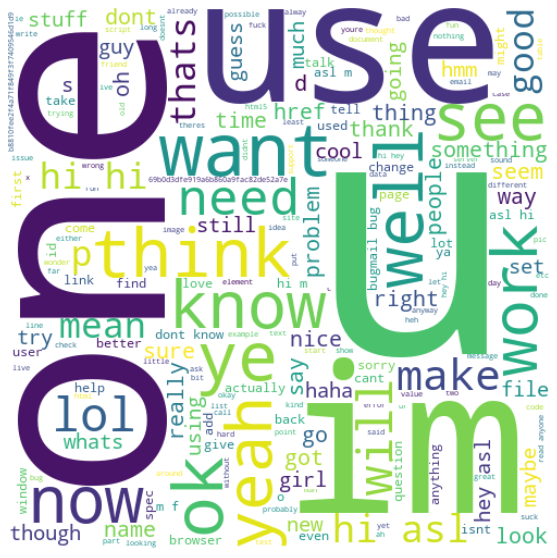

In [90]:
text = " ".join(message for message in dfBase['message'])

wordcloud = WordCloud(width=500, height=500, background_color="white").generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Saving image
wordcloud.to_file("wordcloud.png")

#### WordCloud of sexual predators messages

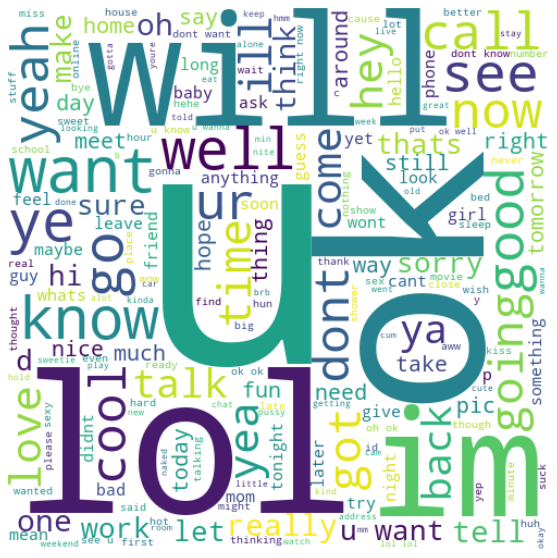

In [91]:
# Returns only messages from authors who are sexual predators
query = '''SELECT * FROM conversations WHERE author in (%s)''' % ','.join('?'*len(SEXUAL_PREDATORS))
aux = pd.read_sql(query, connection, params=SEXUAL_PREDATORS)

text = " ".join(message for message in aux['message'])

wordcloud = WordCloud(width=500, height=500, background_color="white").generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Saving image
wordcloud.to_file("wordcloud_predators.png")

### Save preprocessed dataset

In [ ]:
# Dropping column "original_message"

dfBase.drop('original_message', inplace=True, axis=1)

#### Save predatory conversations dataset

In [ ]:
dfPredatoryConversations = dfBase.copy()

# Returns only messages from authors who are sexual predators
query = '''SELECT * FROM conversations WHERE author in (%s)''' % ','.join('?'*len(SEXUAL_PREDATORS))
aux = pd.read_sql(query, connection, params=SEXUAL_PREDATORS)

predatoryConversations = aux['conversation_id'].unique()

# Adding column "predatory_conversation" with value False initially
# When the conversation is a predatory conversation, the label will be changed to True

dfPredatoryConversations = dfPredatoryConversations.assign(predatory_conversation = False)

for predatoryConversation in predatoryConversations:
  dfPredatoryConversations.loc[(dfPredatoryConversations['conversation_id'] ==  predatoryConversation), ['predatory_conversation']] = True

In [ ]:
dfPredatoryConversations

,conversation_id,line,author,time,message,predatory_conversation
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola,False
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi,False
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up,False
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,False
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,False
...,...,...,...,...,...,...
873197,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,True
873198,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,True
873199,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,True
873200,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,True


In [ ]:
# Number of tuples for each value of the label 'predatory_conversation'

dfPredatoryConversations['predatory_conversation'].value_counts()

False    796290
True      76912
Name: predatory_conversation, dtype: int64

In [ ]:
# Saving predatory conversations dataset

dfPredatoryConversations.to_csv(DRIVE_PATH + 'databases/training_predatoryconversations_preprocessed.csv', index=False, header=True, sep=';')

#### Save predators dataset

In [ ]:
dfPredators = dfBase.copy()

# Adding column "predator" with value False initially
# When the author is a sexual predator, the label will be changed to True

dfPredators = dfPredators.assign(predator = False)

for predator in SEXUAL_PREDATORS:
  dfPredators.loc[(dfPredators['author'] ==  predator), ['predator']] = True

In [ ]:
dfPredators

,conversation_id,line,author,time,message,predator
0,e621da5de598c9321a1d505ea95e6a2d,1,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,hola,False
1,e621da5de598c9321a1d505ea95e6a2d,2,0158d0d6781fc4d493f243d4caa49747,03:20,hi,False
2,e621da5de598c9321a1d505ea95e6a2d,3,0158d0d6781fc4d493f243d4caa49747,03:20,whats up,False
3,e621da5de598c9321a1d505ea95e6a2d,4,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,not a ton,False
4,e621da5de598c9321a1d505ea95e6a2d,5,97964e7a9e8eb9cf78f2e4d7b2ff34c7,03:20,you,False
...,...,...,...,...,...,...
873197,4ed6b02ae537fdfd6078597b706292a8,101,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,oh ok,False
873198,4ed6b02ae537fdfd6078597b706292a8,102,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,i will look for you tomorrow,True
873199,4ed6b02ae537fdfd6078597b706292a8,103,74bfc043bd5ce9c17b37ffae6e0ba2fa,22:36,ok,False
873200,4ed6b02ae537fdfd6078597b706292a8,104,8cd850ea4215ee7c4b94b6bcc0bae593,22:36,bye lissa,True


In [ ]:
# Number of tuples for each value of the label 'predator'

dfPredators['predator'].value_counts()

False    833404
True      39798
Name: predator, dtype: int64

In [ ]:
# Saving predators dataset

dfPredators.to_csv(DRIVE_PATH + 'databases/training_predators_preprocessed.csv', index=False, header=True, sep=';')